### Setup

In [2]:
import tensorflow
from tensorflow import keras
from keras.datasets import mnist
from keras import backend as K
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, BatchNormalization, Conv2D, MaxPooling2D, Input, Dropout, GlobalAveragePooling2D,concatenate
from PIL import Image
import numpy as np
import PIL.ImageOps 
import csv
import zipfile
import os
import cv2
from natsort import natsorted
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import MobileNet
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

Retriving the label data

In [7]:
label_dir = '/content/drive/MyDrive/malaria_project/long_lat_year_2008_to_end.csv'
y_list = []
with open(label_dir) as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  for i,line in enumerate(csv_reader):
    if i == 0:
      continue
    y_list.append(float(line[4]))
y_labels = np.array(y_list)

Now we can retrieve the satellite image data. 

In [15]:
dir_path = "/content/drive/MyDrive/satellite_data"

In [16]:
x_data_map = {}
img_names = []


for i,image in enumerate(os.listdir(dir_path)):
    if image == ".DS_Store" or image ==".ipynb_checkpoints":
        continue
    img_names.append(image)
    img = Image.open(dir_path+"/"+image)

    #crop image
    box = (0, 0, 1024, 1024)
    img = img.crop(box)

    #downscale image to lower resolution #TODO maybe make data generator instead
    img = img.resize((256,256),Image.ANTIALIAS)

    img2np = np.array(img)
    img2np = img2np[:,:,:3] #removing the alpha dimension
    #img2np = img2np.astype('float32')
    #img2np /= 255
    img2np = preprocess_input(img2np)
    img2np = img2np.astype('float32')
    x_data_map[image] = img2np

FileNotFoundError: ignored

Match the correct data point in $x$ with the correct label in $y$ by sorting by the image names.

In [5]:
sorted_keys = natsorted(x_data_map.keys())

x_data = []
for key in sorted_keys:
    x_data.append(x_data_map[key])

x_data = np.array(x_data)
print(y_labels[0])
plt.imshow(x_data[0])

print("Shape:",np.array(x_data).shape)

0.02


IndexError: ignored

In [ ]:
minPixel = 0
maxPixel = 0
for img in x_data:
  if maxPixel < img.max():
    maxPixel = img.max()
  if minPixel > img.min():
    minPixel = img.min()
print(minPixel, maxPixel)


-123.68 151.061


In [ ]:
newMax = maxPixel + abs(minPixel)
for index in x_data_map_copy.keys():
  img = x_data_map[index]
  img = np.array(img)
  img = img + abs(minPixel)
  img = img/newMax
  x_data_map[index] = img

Sanity check that the pixels intensitity values are within [0,1]

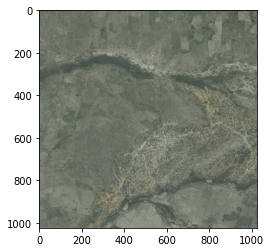

In [ ]:
img = Image.open(dir_path+"/"+'0_42.3478, 2.213.png')
plt.imshow(img)

In [ ]:
print(img2np.max())
print(img2np.min())

52.060997
-80.68


Splitting the data into training and test data. We use the commonly 80/20 split.

In [14]:
dataset_size = x_data.shape[0]
x_train = x_data[:int(dataset_size*0.8)]
x_test = x_data[int(dataset_size*0.8):]
print(x_train.shape, x_test.shape)

dataset_size = x_data.shape[0]
y_train = y_labels[:int(dataset_size*0.8)]
y_test = y_labels[int(dataset_size*0.8):2000] #TODO: remove this when the entire dataset is used
print(len(y_train), len(y_test))

NameError: ignored

Variables

In [ ]:
# img_rows, img_cols= 1024,1024
width = x_data.shape[1]
height = x_data.shape[2]
img_rows, img_cols= height, width
print(img_rows, img_cols)
batch_size = 25
epochs = 100
input_shape = (img_rows, img_cols, 3)

256 256


### Neural Network Model

Now we can define a simple NN model. We use the Sequential which simply is a linear stack of layers.

In [ ]:
#inspiration from https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb#scrollTo=rsf9rD8I17Wq

tensorflow.random.set_seed(0) # make weight initialization deterministic

# Model
model = Sequential()
model.add(Flatten(input_shape=input_shape)) # input_shape is (28, 28, 1)
model.add(Dense(32,activation='relu')) 
model.add(Dense(32,activation='relu')) 
model.add(Dense(32,activation='relu')) 

# model.add(Dense(64,activation='relu')) 
model.add(Dense(1, activation='linear')) 

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 196608)            0         
                                                                 
 dense_4 (Dense)             (None, 32)                6291488   
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,293,633
Trainable params: 6,293,633
Non-trainable params: 0
_________________________________________________________________


Compiling the model

In [ ]:
# model.compile(optimizer='sgd',loss='mean_absolute_error',metrics=['accuracy'])
model.compile(optimizer=tensorflow.keras.optimizers.Adam(0.00001), loss='mean_absolute_error')

Fitting the model

In [ ]:
history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_split=0.2
            )

Epoch 1/100
52/52 [==============================] - 3s 33ms/step - loss: 0.1284 - val_loss: 0.0959
Epoch 2/100
52/52 [==============================] - 1s 24ms/step - loss: 0.1042 - val_loss: 0.1065
Epoch 3/100
52/52 [==============================] - 1s 22ms/step - loss: 0.0948 - val_loss: 0.0795
Epoch 4/100
52/52 [==============================] - 1s 18ms/step - loss: 0.0894 - val_loss: 0.0777
Epoch 5/100
52/52 [==============================] - 1s 17ms/step - loss: 0.0893 - val_loss: 0.1173
Epoch 6/100
52/52 [==============================] - 1s 20ms/step - loss: 0.0889 - val_loss: 0.0936
Epoch 7/100
52/52 [==============================] - 1s 18ms/step - loss: 0.0860 - val_loss: 0.0762
Epoch 8/100
52/52 [==============================] - 1s 17ms/step - loss: 0.0857 - val_loss: 0.0755
Epoch 9/100
52/52 [==============================] - 1s 18ms/step - loss: 0.0883 - val_loss: 0.0751
Epoch 10/100
52/52 [==============================] - 1s 17ms/step - loss: 0.1013 - val_loss: 0.1330

Checking the performance

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score)
# print('Validation accuracy:', score[1])

Test loss: 0.12356751412153244


### Evaluation

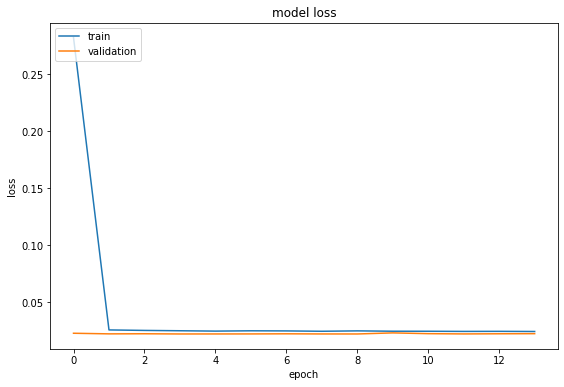

In [ ]:
def show_history(history):
  plt.figure(figsize=(20,6))

  # summarize history for accuracy
  # plt.subplot(121)
  # plt.plot(history.history['accuracy'])
  # plt.plot(history.history['val_accuracy'])
  # plt.title('model accuracy')
  # plt.ylabel('accuracy')
  # plt.xlabel('epoch')
  # plt.legend(['train', 'validation'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

show_history(history)

13/13 [==============================] - 2s 161ms/step


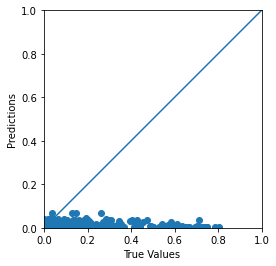

In [ ]:
test_predictions = model.predict(x_test).flatten()

#print("test_predictions", test_predictions)
#print("y_test", y_test)

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values ')
plt.ylabel('Predictions')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
error = test_predictions - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error ')
_ = plt.ylabel('Count')

NameError: ignored

# CNN model

Define the model, inspiration from https://pyimagesearch.com/2019/01/28/keras-regression-and-cnns/

In [ ]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
    # # define the model input
    # inputs = Input(shape=inputShape)

    conv_base = VGG16(weights='imagenet',
                      include_top=False, input_shape =(256,256,3))
    vgg_base = tensorflow.keras.models.Sequential(conv_base.layers[:-1])
    z = vgg_base.output

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # # if this is the first CONV layer then set the input
        # # appropriately
        if i == 0:
            x = z
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)
    # check to see if the regression node should be added

    if regress:
        x = Dense(1, activation="linear")(x)
    # construct the CNN
    model = tensorflow.keras.Model(vgg_base.input, x)
    # return the CNN
    return model

##Train the model

In [ ]:
model = create_cnn(input_shape[0], input_shape[1], 3, regress=True)
opt = tensorflow.keras.optimizers.legacy.Adam(learning_rate=1e-3, decay=1e-3 / 200)
model.compile(loss="huber", optimizer=opt)

# train the model
print("[INFO] training model...")
history = model.fit(x=x_train, y=y_train, 
          verbose=1,
          validation_split=0.2,
          epochs=20, batch_size=32)

[INFO] training model...
Epoch 1/20
40/40 [==============================] - 31s 582ms/step - loss: 0.1869 - val_loss: 1.1957
Epoch 2/20
40/40 [==============================] - 24s 589ms/step - loss: 0.0555 - val_loss: 0.2791
Epoch 3/20
40/40 [==============================] - 23s 573ms/step - loss: 0.0366 - val_loss: 0.0486
Epoch 4/20
40/40 [==============================] - 22s 548ms/step - loss: 0.0291 - val_loss: 0.0440
Epoch 5/20
40/40 [==============================] - 22s 555ms/step - loss: 0.0276 - val_loss: 0.0339
Epoch 6/20
40/40 [==============================] - 23s 578ms/step - loss: 0.0232 - val_loss: 0.0272
Epoch 7/20
40/40 [==============================] - 23s 573ms/step - loss: 0.0222 - val_loss: 0.0239
Epoch 8/20
40/40 [==============================] - 23s 576ms/step - loss: 0.0208 - val_loss: 0.0202
Epoch 9/20
40/40 [==============================] - 23s 580ms/step - loss: 0.0187 - val_loss: 0.0197
Epoch 10/20
40/40 [==============================] - 23s 577ms/ste

## Evaluate the model

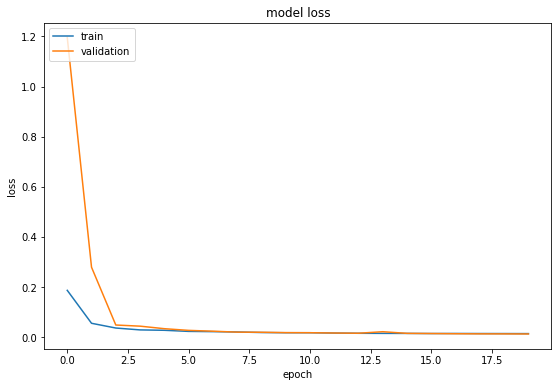

In [ ]:
show_history(history)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score)

Test loss: 0.024335671216249466


13/13 [==============================] - 2s 163ms/step


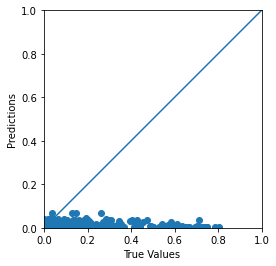

In [ ]:
test_predictions = model.predict(x_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values ')
plt.ylabel('Predictions')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Late Fusion with Land Cover

In [5]:
'''Open and fix shape of land cover images'''
land_cover_data_map = {}
land_cover_img_names = []

dir_path = "/content/drive/MyDrive/malaria_project/landcover_with_confi_2010_2018_size10andGreater" #/content/x_data/x/8.png
for i,image in enumerate(os.listdir(dir_path)):
    if image == ".DS_Store" or image ==".ipynb_checkpoints":
        continue
    land_cover_img_names.append(image)
    img = Image.open(dir_path+"/"+image)
    #img.show()

    #crop image
    box = (0, 0, 8, 8)
    img = img.crop(box)

    #downscale image to lower resolution #TODO maybe make data generator instead
    #img = img.resize((256,256),Image.ANTIALIAS)

    img2np = np.array(img)
    img2np = img2np[:,:] #removing the alpha dimension
    img2np = img2np.astype('float32')
    img2np /= 200 #unknown has intensity value 200
    land_cover_data_map[image] = img2np


0.02
Shape: (6667, 8, 8)


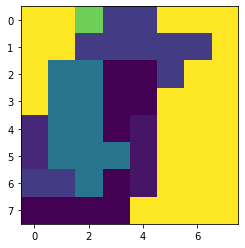

In [8]:
# Match the correct data point in X with the correct label in y by sorting by the image names.
sorted_keys = natsorted(land_cover_data_map.keys())

x_data_land_cover = []
for key in sorted_keys:
    x_data_land_cover.append(land_cover_data_map[key])

x_data_land_cover = np.array(x_data_land_cover)
print(y_labels[0])
plt.imshow(x_data_land_cover[0])

print("Shape:",np.array(x_data_land_cover).shape)

In [9]:
dataset_size = x_data_land_cover.shape[0]
x_train_land_cover = x_data_land_cover[:int(dataset_size*0.8)]
x_test_land_cover = x_data_land_cover[int(dataset_size*0.8):]

print(x_train_land_cover.shape, x_test_land_cover.shape)

(5333, 8, 8) (1334, 8, 8)


In [10]:
def create_late_fusion_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
    # # define the model input
    # inputs = Input(shape=inputShape)

    conv_base = VGG16(weights='imagenet',
                      include_top=False, input_shape =(256,256,3))
    vgg_base = tensorflow.keras.models.Sequential(conv_base.layers[:-1])
    z = vgg_base.output

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # # if this is the first CONV layer then set the input
        # # appropriately
        if i == 0:
            x = z
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)
    # check to see if the regression node should be added
    x = Dense(1, activation="linear")(x)

    '''Land Cover Model (LCM)'''
    inputShape_landcover = (1,8,8)
    x2 = Sequential()
    x2 = Conv2D(filters=16,kernel_size=(4,4), padding="same", activation="relu")
    x2 = BatchNormalization(axis=-1)(x2)
    x2 = MaxPooling2D(pool_size=(3,3))(x2)
    x2 = Conv2D(filters=32, stride=(4,4), padding="same", activation="relu")
    x2 = BatchNormalization(axis=-1)(x2)
    x2 = MaxPooling2D(pool_size=(3,3))(x2)
    x2 = Flatten()(x2)
    x2 = Dense(1, activation="linear")(x2)
    

    
    x_combined = concatenate([x,x2])
    x_combined = Sequential(x_combined)
    prediction = Dense(1, activation="relu")(x_combined)

        
    # construct the CNN
    model = tensorflow.keras.Model(inputs=[vgg_base.input, x2], output=prediction)
    # return the CNN
    return model

In [12]:
'''VGG base model'''
base_model1 = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
#freeze layers
for layer in base_model1.layers:
    layer.trainable = False

x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Dropout(0.2)(x1)


'''Land Cover'''
#base_model2 = keras.layers.Input(shape=(21, ))
base_model2 = Sequential()#(input1)
#base_model2.add(Dense(16,activation='relu'))
#base_model2.add(Dropout(0.2))
#base_model2.add(Dense(8,activation='relu'))
#base_model2.add(Dropout(0.2))
#base_model2.add(Dense(4,activation='relu'))
#base_model2.add(Flatten())
pool_size = 2
base_model2.add(Conv2D(filters=16,kernel_size=3, padding="same", activation="relu"))
base_model2.add(BatchNormalization(axis=-1))
base_model2.add(MaxPooling2D(pool_size=pool_size))
base_model2.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
base_model2.add(BatchNormalization(axis=-1))
base_model2.add(MaxPooling2D(pool_size=pool_size))
base_model2.add(Flatten())
base_model2.add(Dense(1, activation="linear"))
base_model2.build((None,8,8,1))
x2 = base_model2.output


'''Combining'''
x_combined = concatenate([x1,x2])
x_combined = Sequential()(x_combined)
predictions = Dense(1, activation="relu")(x_combined)

modelWithLandcover = Model(inputs=[base_model1.input, base_model2.input], outputs=predictions) 
modelWithLandcover.compile(optimizer='adam', loss='huber')
#model.build([(None,256,256),(None,21,21)])
summary = modelWithLandcover.summary()




#base_model2.compile(optimizer='adam', loss='huber')
#base_model2.build((None,21,21))
#base_model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [13]:
modelWithLandcover.compile(optimizer='adam', loss='mse')
history = modelWithLandcover.fit(x=[x_train,x_train_land_cover], y=[y_train,y_train], 
          verbose=1,
          validation_split=0.2,
          epochs=10, batch_size=32)

NameError: ignored

In [ ]:
show_history(history)
score = model.evaluate(x=[x_test,x_test_land_cover], y=y_test, verbose=0)
print('Test loss:', score)
test_predictions = model.predict(x=[x_test,x_test_land_cover]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values ')
plt.ylabel('Predictions')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)



In [ ]:
'''VGG base model'''
base_model1 = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
#freeze layers
for layer in base_model1.layers:
    layer.trainable = False

top_model = base_model1.output
#top_model = Flatten(name="flatten")(top_model)
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(4096, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
top_model = Dense(2048, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
top_model = Dense(1024, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
output_layer = Dense(1, activation='linear')(top_model)

model = Model(inputs=base_model1.input, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
model.compile(optimizer='RMSprop', loss='huber', metrics=['mse','mae'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(x=x_train, y=y_train, 
          verbose=1, callbacks=[callback],
          validation_split=0.2,
          epochs=30, batch_size=8)

NameError: ignored

In [ ]:
show_history(history)
score = model.evaluate(x=x_test, y=y_test, verbose=0)
print('Test loss:', score)
test_predictions = model.predict(x=x_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values ')
plt.ylabel('Predictions')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)



# ImageDataGenerator

We use the split-folders library to make the satellite images into test, training and validation data. Using the ratios training (70%), validation (20%) and testing (10%)

In [18]:
# !pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/content/drive/MyDrive/x_data/", output="output",
    seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=False) # (train:validation:test)


Copying files: 2000 files [00:54, 36.98 files/s] 


In [88]:
'''
This function is responsible for creating the dataframe containing the labels and image data
'''
def createDataFrame(label_dir, data_dir):
  #Retrieve the ids
  ids = []
  for file in os.listdir(data_dir):
    ids.append(file)
  #Create empty DataFrame
  df = pd.DataFrame()
  #Append the data
  df['filename'] = ids
  #Append placeholder for the labels
  df['label'] = ['0' for i in range(len(ids))]

  #Append the scores/labels
  with open(label_dir) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for i,line in enumerate(csv_reader):
      id = line[0]
      pr = line[4]
      for img in ids:
        img_id, _ = img.split('_')
        if img_id == id:
          index = np.where(df["filename"] == img)
          df['label'].loc[index] = float(pr)
  return df

Creating the dataframes

In [89]:
train_data_dir = 'output/train/satellite_data'
test_data_dir = 'output/test/satellite_data'
val_data_dir = 'output/val/satellite_data'
label_dir = '/content/drive/MyDrive/malaria_project/long_lat_year_2008_to_end.csv'

train_df = createDataFrame(label_dir=label_dir, data_dir=train_data_dir)
test_df = createDataFrame(label_dir=label_dir, data_dir=test_data_dir)
val_df = createDataFrame(label_dir=label_dir, data_dir=val_data_dir)

In [90]:
print(val_df)

                       filename     label
0       606_35.3963, 0.6119.png       0.0
1     1311_40.1081, -3.1279.png  0.027778
2      1393_44.8171, 4.5138.png       0.0
3       61_31.3682, -7.3199.png  0.116279
4       394_43.7071, 1.2088.png       0.0
..                          ...       ...
395  1966_34.5155, -13.9582.png  0.574468
396     139_46.6275, 3.3906.png       0.0
397      207_46.3396, 3.043.png       0.0
398   1865_39.5473, -4.2802.png  0.285714
399   1871_39.5751, -4.2766.png  0.026316

[400 rows x 2 columns]


Now we can create the datagenerators using Keras' ImageDataGenerator.

In [91]:
BATCH_SIZE=8
train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, 
                                                      directory=train_data_dir, 
                                                      x_col="filename", y_col="label", has_ext=True, 
                                                      class_mode="raw", target_size=(1024, 1024), 
                                                      batch_size=BATCH_SIZE)

validation_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = validation_datagen.flow_from_dataframe(dataframe=val_df, 
                                                      directory=val_data_dir,
                                                      x_col="filename", y_col="label", has_ext=True,
                                                      class_mode="raw", target_size=(1024,1024),
                                                      batch_size=BATCH_SIZE)

Found 1400 validated image filenames.
Found 400 validated image filenames.


Testing using the basic neural network

In [92]:
# Model
model = Sequential()
model.add(Flatten(input_shape=(1024,1024,3))) # input_shape is (28, 28, 1)
model.add(Dense(32,activation='relu')) 
model.add(Dense(32,activation='relu')) 
model.add(Dense(32,activation='relu')) 

# model.add(Dense(64,activation='relu')) 
model.add(Dense(1, activation='linear')) 
model.compile(loss="mae", optimizer="Adam")
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 3145728)           0         
                                                                 
 dense_67 (Dense)            (None, 32)                100663328 
                                                                 
 dense_68 (Dense)            (None, 32)                1056      
                                                                 
 dense_69 (Dense)            (None, 32)                1056      
                                                                 
 dense_70 (Dense)            (None, 1)                 33        
                                                                 
Total params: 100,665,473
Trainable params: 100,665,473
Non-trainable params: 0
_________________________________________________________________


In [93]:
#https://stackoverflow.com/questions/64978209/valueerror-when-trying-to-execute-model-fit-failed-to-convert-a-numpy-array/
train_generator._targets = np.stack(train_generator._targets)
val_generator._targets = np.stack(val_generator._targets)

model.fit(train_generator, verbose=1)

  7/175 [>.............................] - ETA: 1:21 - loss: 136.8123

KeyboardInterrupt: ignored

In [26]:
# !pip install livelossplot --quiet

Now we can try using the VGG model

In [57]:
'''VGG base model'''
base_model1 = VGG16(weights='imagenet', include_top=False, input_shape=(1024, 1024, 3))
# base_model1 = tensorflow.keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(1024, 1024, 3))

#freeze layers
for layer in base_model1.layers:
    layer.trainable = False

top_model = base_model1.output
#top_model = Flatten(name="flatten")(top_model)
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(4096, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
top_model = Dense(2048, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
top_model = Dense(1024, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
output_layer = Dense(1, activation='linear')(top_model)

vgg_model = Model(inputs=base_model1.input, outputs=output_layer)
vgg_model.compile(optimizer='adam', loss='mse')
#model.summary()

We can modify the datagenerators to include the preprocessing from VGG

In [58]:
train_datagen = ImageDataGenerator(
                    preprocessing_function=preprocess_input,
                    rescale = 1./255,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, 
                                                      directory=train_data_dir, 
                                                      x_col="filename", y_col="label", has_ext=True, 
                                                      class_mode="raw", target_size=(1024, 1024), 
                                                      batch_size=BATCH_SIZE)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,rescale = 1./255)

val_generator = validation_datagen.flow_from_dataframe(dataframe=val_df, 
                                                      directory=val_data_dir,
                                                      x_col="filename", y_col="label", has_ext=True,
                                                      class_mode="raw", target_size=(1024,1024),
                                                      batch_size=BATCH_SIZE)
#https://stackoverflow.com/questions/64978209/valueerror-when-trying-to-execute-model-fit-failed-to-convert-a-numpy-array/
train_generator._targets = np.stack(train_generator._targets)
val_generator._targets = np.stack(val_generator._targets)

Found 1400 validated image filenames.
Found 400 validated image filenames.


In [59]:
BATCH_SIZE = 8
input_shape = (1024, 1024, 3)
optim_1 = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

n_steps = train_generator.samples // BATCH_SIZE
n_val_steps = val_generator.samples // BATCH_SIZE
n_epochs = 1

In [60]:
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           restore_best_weights=True,
                           mode='min')

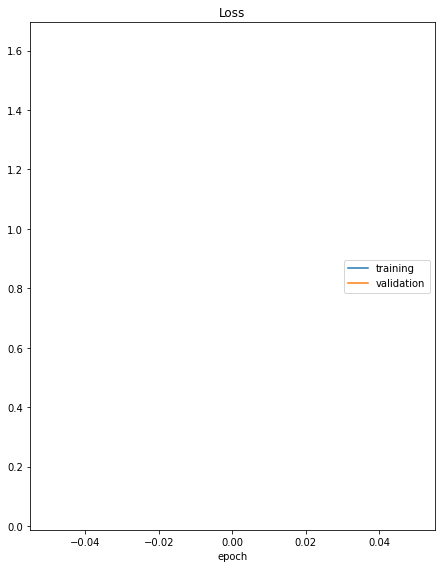

Loss
	training         	 (min:    1.617, max:    1.617, cur:    1.617)
	validation       	 (min:    0.065, max:    0.065, cur:    0.065)
175/175 [==============================] - 215s 1s/step - loss: 1.6170 - val_loss: 0.0652


In [61]:
vgg_history = vgg_model.fit(train_generator,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=val_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

# Generator & late fusion land cover


In [73]:

'''Transfer base model'''
base_model1 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#freeze layers
for layer in base_model1.layers:
    layer.trainable = False

top_model = base_model1.output
#top_model = Flatten(name="flatten")(top_model)
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(4096, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
top_model = Dense(2048, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
top_model = Dense(1024, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
x1 = Dense(1, activation='linear')(top_model)


'''Land Cover'''
#base_model2 = keras.layers.Input(shape=(21, ))
base_model2 = Sequential()#(input1)
#base_model2.add(Dense(16,activation='relu'))
#base_model2.add(Dropout(0.2))
#base_model2.add(Dense(8,activation='relu'))
#base_model2.add(Dropout(0.2))
#base_model2.add(Dense(4,activation='relu'))
#base_model2.add(Flatten())
pool_size = 2
base_model2.add(Conv2D(filters=16,kernel_size=3, padding="same", activation="relu"))
base_model2.add(BatchNormalization(axis=-1))
base_model2.add(MaxPooling2D(pool_size=pool_size))
base_model2.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
base_model2.add(BatchNormalization(axis=-1))
base_model2.add(MaxPooling2D(pool_size=pool_size))
base_model2.add(Flatten())
base_model2.add(Dense(1, activation="linear"))
base_model2.build((None,8,8,1))
x2 = base_model2.output


'''Combining'''
x_combined = concatenate([x1,x2])
x_combined = Sequential()(x_combined)
predictions = Dense(1, activation="relu")(x_combined)

modelWithLandcover = Model(inputs=[base_model1.input, base_model2.input], outputs=predictions) 
modelWithLandcover.compile(optimizer='adam', loss='huber')
#model.build([(None,256,256),(None,21,21)])
# summary = modelWithLandcover.summary()

In [74]:

BATCH_SIZE=8
train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, 
                                                      directory=train_data_dir, 
                                                      x_col="filename", y_col="label", has_ext=True, 
                                                      class_mode="raw", target_size=(1024, 1024), 
                                                      batch_size=BATCH_SIZE)

validation_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = validation_datagen.flow_from_dataframe(dataframe=val_df, 
                                                      directory=val_data_dir,
                                                      x_col="filename", y_col="label", has_ext=True,
                                                      class_mode="raw", target_size=(1024,1024),
                                                      batch_size=BATCH_SIZE)

Found 1400 validated image filenames.
Found 400 validated image filenames.


In [75]:
model_history = modelWithLandcover.fit(train_generator,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=val_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

ValueError: ignored

In [ ]:
'''
This function is responsible for creating the dataframe containing the labels and image data
'''
def createDataFrame_LC(label_dir, data_dir):
  #Retrieve the ids
  ids = []
  for file in os.listdir(data_dir):
    ids.append(file)
  #Create empty DataFrame
  df = pd.DataFrame()
  #Append the data
  df['filename'] = ids
  #Append placeholder for the labels
  df['label'] = ['0' for i in range(len(ids))]

  #Append the scores/labels
  with open(label_dir) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for i,line in enumerate(csv_reader):
      id = line[0]
      pr = line[4]
      for img in ids:
        img_id, _ = img.split('_')
        if img_id == id:
          index = np.where(df["filename"] == img)
          df['label'].loc[index] = float(pr)
  return df

In [100]:
lc_path = "/content/drive/MyDrive/malaria_project/landcover_with_confi_2010_2018_size10andGreater"
print(label_dir)
print(lc_path)
createDataFrame(label_dir=label_dir, data_dir=lc_path)

/content/drive/MyDrive/malaria_project/long_lat_year_2008_to_end.csv
/content/drive/MyDrive/malaria_project/landcover_with_confi_2010_2018_size10andGreater


ValueError: ignored